> __Purpose__: The purpose of this notebook is to take the best meta model from NB75, then test it on unseen data, and use this to determine the performance of how the validation checks are performing (e.g. are the validation checks working as expected).

In [23]:
#no_test

#data structure imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from os import listdir

#python imports
import random

#modeling imports
from spacy.util import fix_random_seed
from ssda_nlp.collate import *
from ssda_nlp.split_data import *
from ssda_nlp.modeling import *
from ssda_nlp.preprocessing import *
from ssda_nlp.model_performance_utils import *
from ssda_nlp.utility import *
from ssda_nlp.relationships import *
from ssda_nlp.full_volume import *

from ssda_nlp.xml_parser import *
from ssda_nlp.unstructured2markup import *
import json
import copy

from ssda_nlp.validation_visuals import *

#if you want the same model everytime:
seed = 2436
random.seed(seed)
fix_random_seed(seed)

## From NB 74
- Update to best meta model. Doesn't need to rotate through multiple models

In [3]:
#no_test

#row names: people, places, events, json_path, entities, noCategory, validation_list
num_rows = 7
cols = np.zeros((num_rows,1))

path = 'models/75'
best_model_path = path + r"/" + "best_meta_model"

#"transcriptions\\15834.xml", "models/15834"
my_trans = "transcriptions\\15834.xml"
my_dir = best_model_path
people, places, events, json_path, entities, noCategory, validation_list = process_volume(my_trans, my_dir)
print("--------------------------------------")

Loaded model 'models/75/best_meta_model'
Entities extracted.
Enslaver found, but thinks principal is not enslaved... Principal dict:
[{'id': '15834-1033-3-P1;15834-1033-3-P3', 'name': 'Maria', 'origin': None, 'ethnicities': None, 'age': None, 'legitimacy': None, 'occupation': None, 'phenotype': None, 'status': 'Esc.a', 'titles': None, 'ranks': None, 'relationships': [{'related_person': '15834-1033-3-P6', 'relationship_type': 'godparent'}, {'related_person': '15834-1033-3-P5', 'relationship_type': 'enslaver'}]}]
-------------------------
Enslaver found, but thinks principal is not enslaved... Principal dict:
[{'id': '15834-1034-3-P1;15834-1034-3-P3', 'name': 'Antonia', 'origin': None, 'ethnicities': 'mina', 'age': 'adulta', 'legitimacy': None, 'occupation': None, 'phenotype': 'negra', 'status': 'Esc.va', 'titles': None, 'ranks': None, 'relationships': [{'related_person': '15834-1034-3-P5', 'relationship_type': 'godparent'}, {'related_person': '15834-1034-3-P4', 'relationship_type': 'ens

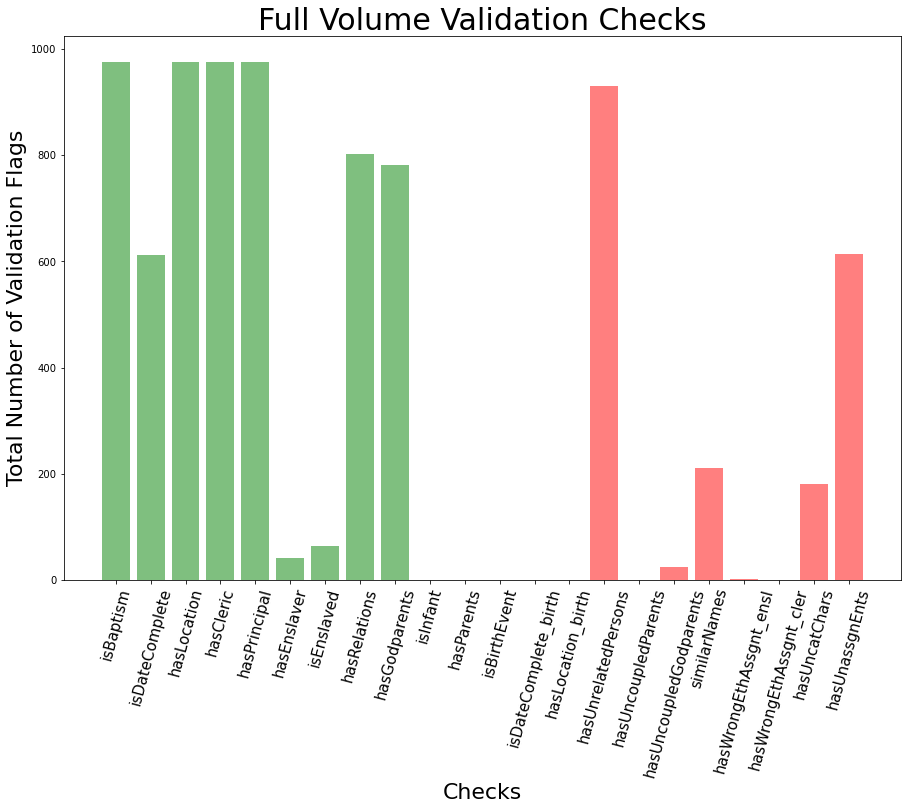

In [4]:
#no_test
val_vis_bar(validation_list)

In [17]:
path_to_transcription = my_trans
path_to_model = best_model_path

In [24]:
#def process_volume(path_to_transcription, path_to_model):
'''
runs the transcription of a single volume (formatted according to SSDA markup 2.0 specs) through the ML entity extraction
and rules-based relationship linking pipelines, then formats resulting data for export into SQL
    path_to_transcription: path to an XML file containing the transcription of a single volume
    path_to_model: path to a spaCy model trained to extract entities from the proper type of volume

    returns: final people, place, and event dictionaries as well as the
    path to a JSON file containing volume metadata as well as people, place, and event records
'''

#retrieve volume metadata and controlled vocabularies

volume_metadata = retrieve_volume_metadata(path_to_transcription)
images = xml_v2_to_json(path_to_transcription)
vocabularies = retrieve_controlled_vocabularies()

if volume_metadata["country"] == "Brazil":
    lang = "pt"
    language = "portuguese"
else:
    lang = "es"
    language = "spanish"

#load and apply trained model

trained_model = load_model(path_to_model, language=lang, verbose='True')

entry_df = parse_xml_v2(path_to_transcription)

ent_preds_df, metrics_df, per_ent_metrics = test_model(trained_model, entry_df, "entry_no", "text", score_model=False)
print("Entities extracted.")

validation_dict_ALL = []

#file path could be passed as parameter, as could language (eventually)
with open("names.json", encoding="utf-8") as infile:
    name_file = json.load(infile)

names = name_file["names"]
all_first_names = []
for name in names:
    all_first_names.append(name["name"])        

for i in range(len(entry_df.index)):

    entry_no = entry_df['entry_no'][i]
    entry_text = entry_df['text'][i]    

    entities = copy.deepcopy(ent_preds_df[ent_preds_df['entry_no'] == entry_no])

    entities["assigned"] = True

    entry_people, entry_places, entry_events, entities, characteristics_df, categorized_characteristics, uncategorized_characteristics = build_entry_metadata(entry_text, entities, path_to_transcription, entry_no)   

Loaded model 'models/75/best_meta_model'
Entities extracted.


In [29]:
validation_list[0]

{'isBaptism': True,
 'isDateComplete': False,
 'hasLocation': True,
 'hasCleric': True,
 'hasPrincipal': True,
 'hasEnslaver': True,
 'isEnslaved': True,
 'hasRelations': True,
 'hasGodparents': True,
 'isInfant': False,
 'hasParents': False,
 'isBirthEvent': False,
 'isDateComplete_birth': False,
 'hasLocation_birth': False,
 'hasUnrelatedPersons': True,
 'hasUncoupledParents': False,
 'hasUncoupledGodparents': False,
 'similarNames': False,
 'hasWrongEthAssgnt_ensl': False,
 'hasWrongEthAssgnt_cler': False,
 'hasUncatChars': False,
 'hasUnassgnEnts': False}

The above indicates that the first entry to the validation list has unrelated persons.  Let's check that below.  We will print out the people and see if anyone is unrelated

In [27]:
print(len(entry_people))
print(entry_people)

[{'id': '15834-1342-1-P1',
  'name': 'Joseph Antonio',
  'origin': None,
  'ethnicities': None,
  'age': 'niño',
  'legitimacy': None,
  'occupation': None,
  'phenotype': None,
  'status': None,
  'titles': None,
  'ranks': None,
  'relationships': [{'related_person': '15834-1342-1-P5',
    'relationship_type': 'godparent'}]},
 {'id': '15834-1342-1-P2',
  'name': 'Maria de la Concepsion Congo',
  'origin': None,
  'ethnicities': 'Congo',
  'age': None,
  'legitimacy': None,
  'occupation': None,
  'phenotype': None,
  'status': 'esclava',
  'titles': None,
  'ranks': None,
  'relationships': [{'related_person': '15834-1342-1-P3',
    'relationship_type': 'enslaver'}]},
 {'id': '15834-1342-1-P3',
  'name': 'D.n Miguel Otero',
  'origin': None,
  'ethnicities': None,
  'age': None,
  'legitimacy': None,
  'occupation': None,
  'phenotype': None,
  'status': None,
  'titles': None,
  'ranks': None,
  'relationships': [{'related_person': '15834-1342-1-P2',
    'relationship_type': 'slave'

Okay, so 'Jsph Antonio' has no relations.  This checks out.  However, it sounds like he might be the first person in the entry ('Joseph Antonio').  Let's print the entry text and read it to determine if they are different people, the same person, or if the model is drawing two different people from the same verbatim text.

In [30]:
entry_text

'[margin]: Joseph Antonio Domingo trece de Agosto de mil Setesientos Cinq.a y dos Yo el D.r D.n Lorenso Noriega y Marroquin Cura benefic.do de la parroq.l de S.n Carlos [roto] Math.s Baptisé y puse los S.tos Oleos a un niño que nació á dos de dho mes hijo de Maria de la Concepsion Congo Soltera esclava de D.n Miguel Otero en el qual exerci las Sacras Ceremonias y preses y le puse p.r [roto] bre Jsph Antonio fue su Padrino Fernando del Castillo = y lo firmé = '

So it turns out his name appears first, and then in the last line as well.  The model is incorrectly identifying him as two different people.  However, this really should be flagged under the SimilarNames tag as well.

In [31]:
#no_test
from nbdev.export import notebook2script
notebook2script();

Converted 12-ssda-xml-parser.ipynb.
Converted 31-collate-xml-entities-spans.ipynb.
Converted 33-split-data.ipynb.
Converted 41-generic-framework-for-spacy-training.ipynb.
Converted 42-initial-model.ipynb.
Converted 51-data-preprocessing.ipynb.
Converted 52-unstructured-to-markup.ipynb.
Converted 53-markup-to-spatial-historian.ipynb.
Converted 54-utility-functions.ipynb.
Converted 61-prodigy-output-training-demo.ipynb.
Converted 62-full-model-application-demo.ipynb.
Converted 63-pt-model-training.ipynb.
Converted 64-es-model-training.ipynb.
Converted 65-all-annotations-model-training.ipynb.
Converted 66-es-guatemala-model-training.ipynb.
Converted 67-death-and-birth-records-together.ipynb.
Converted 70-exhaustive-training.ipynb.
Converted 71-relationship-builder.ipynb.
Converted 72-full-volume-processor.ipynb.
Converted 73-table-output.ipynb.
Converted 74-validation-visuals.ipynb.
Converted 75-meta-model.ipynb.
Converted 76-val-check-verif.ipynb.
